In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import sys
import math
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import os
import csv
from helpers.outliers import MyOutliers
from skroutz_mobile import SkroutzMobile
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from skroutz_mobile import SkroutzMobile
from sklearn.model_selection import StratifiedShuffleSplit
from helpers.my_train_test_split import MySplitTrainTest
from sklearn.preprocessing import StandardScaler
from preprocess_price_history import PreprocessPriceHistory
from price_history import PriceHistory
from dfa import dfa
import scipy.signal as ss
import nolds
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import silhouette_score
from os.path import isfile
from preprocess_price_history import PreprocessPriceHistory

In [3]:
random_state = np.random.RandomState(seed=16011984)
%matplotlib inline

In [4]:
window = 3
maxlag = 4

## Some processing

In [5]:
csv_in = "../price_history_03_seq_start_suddens_trimmed.csv"

In [6]:
#csv_out = "../price_history_for_sfa.csv"
#df_fixed_width.to_csv(csv_path, encoding='utf-8', quoting=csv.QUOTE_ALL)

In [7]:
ph = PriceHistory(csv_in)

In [8]:
seq = ph.extractSequenceByLocation(0)
print type(seq)
seq.shape, seq.name

<class 'pandas.core.series.Series'>


((210,), 10084353)

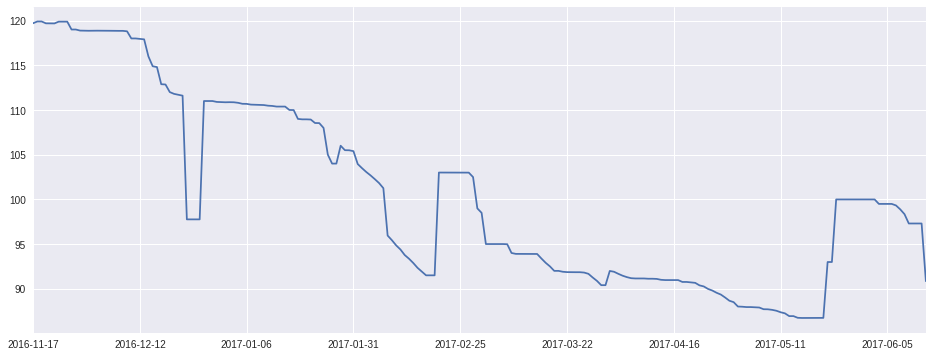

In [9]:
#seq
plt.figure(figsize=(16,6))
seq.plot()
plt.show()

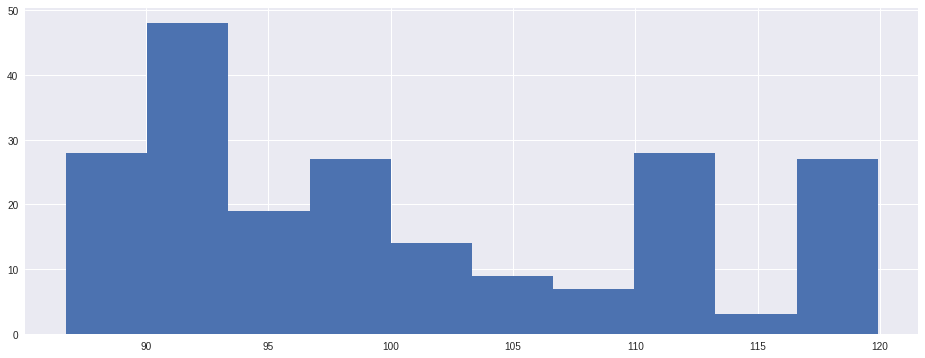

In [10]:
plt.figure(figsize=(16,6))
seq.hist()
plt.show()

# Dickey Fuller Test
http://machinelearningmastery.com/time-series-data-stationary-python/

In [11]:
from statsmodels.tsa.stattools import adfuller

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
def dickey_fuller_print(sequence):
    result = adfuller(sequence)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
def dickey_fuller_test(sequence, threshold=0.05):
    result = adfuller(sequence, maxlag=maxlag)
    return result[1] < threshold

In [14]:
def dickey_fuller_p(sequence):
    result = adfuller(sequence, maxlag=maxlag)
    return result[1]

In [15]:
dickey_fuller_print(seq)

ADF Statistic: -1.769697
p-value: 0.395606
Critical Values:
	5%: -2.876
	1%: -3.463
	10%: -2.574


# Analyzing dickey fuller p values for raw time series

In [16]:
seqs = ph.extractAllSequences()

In [17]:
pvals = [dickey_fuller_p(seq) for seq in seqs if maxlag < len(seq) - 1]

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [18]:
len(pvals)

681

In [19]:
pvals = [pval for pval in pvals if not np.isnan(pval)]
len(pvals)

612

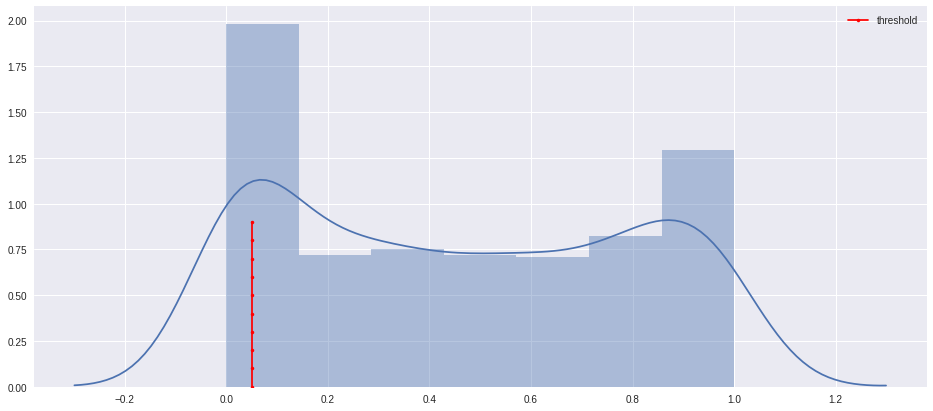

In [20]:
plt.figure(figsize=(16,7))
sns.distplot(pvals)
plt.plot(np.full(10, 0.05), np.arange(0, 1, 0.1), 'r.-', label='threshold')
plt.legend()
plt.show()

We see that almost all time series when unpreprocessed/raw are above threshold

# One Differencing (Diff-1) of time series and Dickey-Fuller Test

In [21]:
seq.diff()

2016-11-17      NaN
2016-11-18     0.01
2016-11-19     0.97
2016-11-20    -0.07
2016-11-21     5.00
2016-11-22    -9.90
2016-11-23     0.00
2016-11-24     0.00
2016-11-25     6.00
2016-11-26     0.00
2016-11-27     0.00
2016-11-28     0.00
2016-11-29     0.00
2016-11-30   -11.00
2016-12-01    11.00
2016-12-02     0.00
2016-12-03     0.00
2016-12-04     0.00
2016-12-05     0.00
2016-12-06     0.00
2016-12-07    -1.00
2016-12-08     1.00
2016-12-09     0.00
2016-12-10     0.00
2016-12-11    -1.21
2016-12-12    -0.79
2016-12-13     2.00
2016-12-14     0.00
2016-12-15     0.00
2016-12-16     0.00
              ...  
2017-05-16     0.00
2017-05-17     0.00
2017-05-18     0.01
2017-05-19     0.00
2017-05-20     0.00
2017-05-21     0.00
2017-05-22     0.00
2017-05-23     0.00
2017-05-24     0.00
2017-05-25     0.00
2017-05-26    12.50
2017-05-27     0.00
2017-05-28     0.00
2017-05-29     0.00
2017-05-30     8.00
2017-05-31     0.00
2017-06-01     0.99
2017-06-02    -0.19
2017-06-03     0.19


In [22]:
seqs_diff = [seq.diff()[1:] for seq in seqs]

In [23]:
pvals_diff = [dickey_fuller_p(seq) for seq in seqs_diff if maxlag < len(seq) - 1]
len(pvals_diff)

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/base/model.py:1118: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale


679

In [24]:
pvals_diff = [pval for pval in pvals_diff if not np.isnan(pval)]
len(pvals_diff)

611

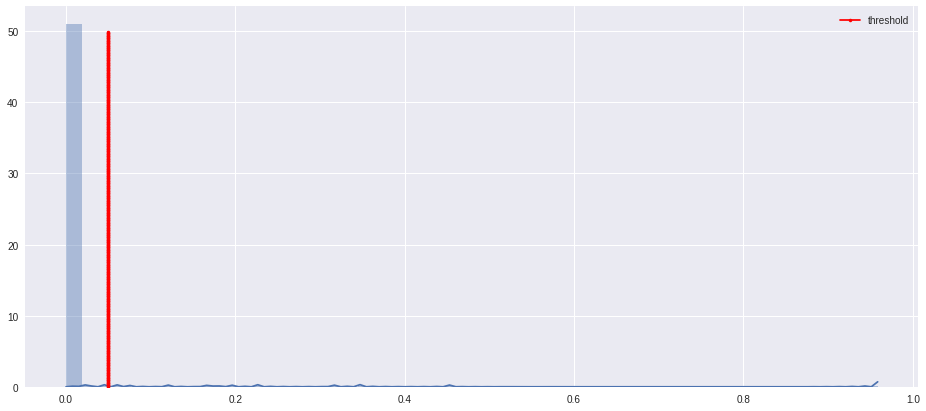

In [32]:
plt.figure(figsize=(16,7))
sns.distplot(pvals_diff)
plt.plot(np.full(int(50/0.1), 0.05), np.arange(0, 50, 0.1), 'r.-', label='threshold')
plt.legend()
#plt.yscale('log')
plt.show()

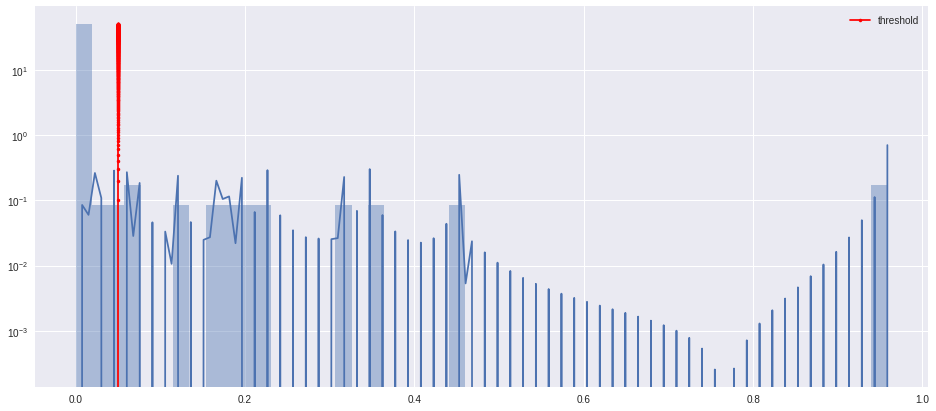

In [25]:
plt.figure(figsize=(16,7))
sns.distplot(pvals_diff)
plt.plot(np.full(int(50/0.1), 0.05), np.arange(0, 50, 0.1), 'r.-', label='threshold')
plt.legend()
plt.yscale('log')
plt.show()

#### Conclusion
We see that by differencing the vast majority of the time series have become stationary

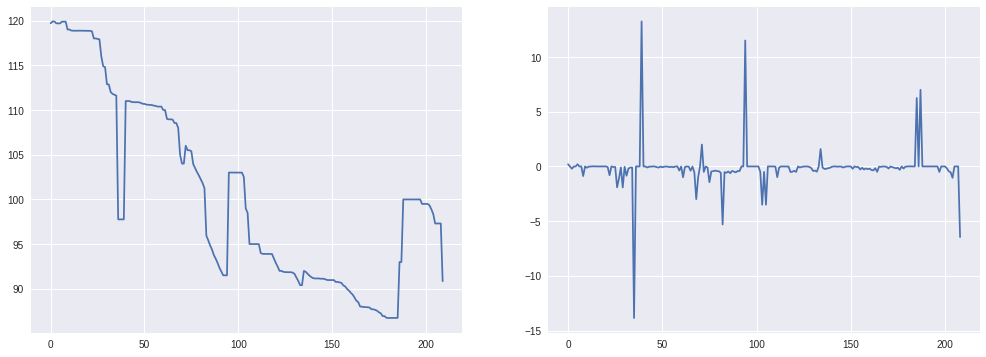

In [31]:
figs, axes = plt.subplots(1, 2, figsize=(17,6))
#plt.figure()
#seqs_diff[np.random.randint(len(seqs_diff))].plot()
axes[0].plot(seqs[0].values)
axes[1].plot(seqs_diff[0].values)
#.plot()
plt.show()

## Quick Gaussian Process Regressor test

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [40]:
gp = GaussianProcessRegressor()

In [41]:
XX = np.arange(len(seq.index)).reshape(1, -1)
XX.shape

(1, 210)

In [42]:
yy = seq.values

In [43]:
gp.fit(XX.T, yy)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [44]:
preds = gp.predict(XX.T)
preds.shape

(210,)

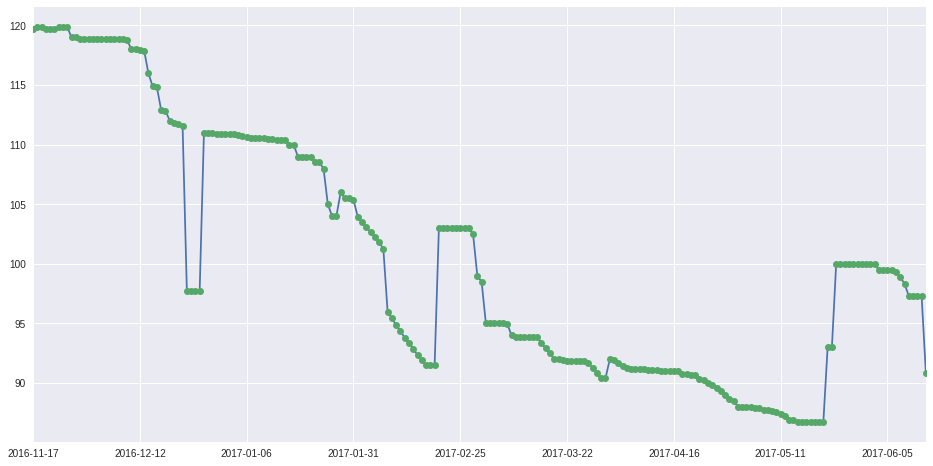

In [45]:
plt.figure(figsize=(16,8))
seq.plot()
plt.plot(preds, 'o')
plt.show()

In [139]:
#preds - seq.values

# Correlation

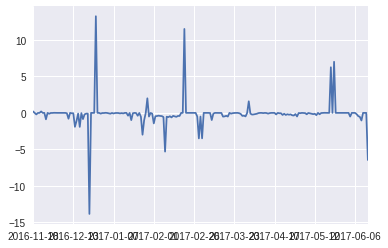

In [59]:
seq = seqs_diff[0]
seq.plot()
plt.show()

In [60]:
seq1 = seqs_diff[1]

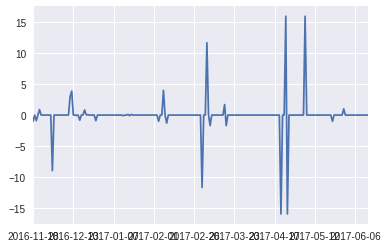

In [62]:
seq1.plot()
plt.show()

In [63]:
seq.corr(seq1)

0.026569344851992815

In [69]:
corels = np.empty(shape=[len(seqs_diff)] * 2)
corels.shape

(689, 689)

In [35]:
cur_len = len(seqs_diff)
cur_len

689

In [71]:
assert np.all([np.all(cur_seq == cur_seq) for cur_seq in seqs_diff]), "we should not have any nan values"

In [33]:
%%time
filename = 'time_series_diff_correlations.npy'
if isfile(filename):
    corels = np.load(filename)
else:
    for ii in range(cur_len):
        for jj in range(cur_len):
            corels[ii, jj] = seqs_diff[ii].corr(seqs_diff[jj])
            
    np.save(filename, corels)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 112 ms


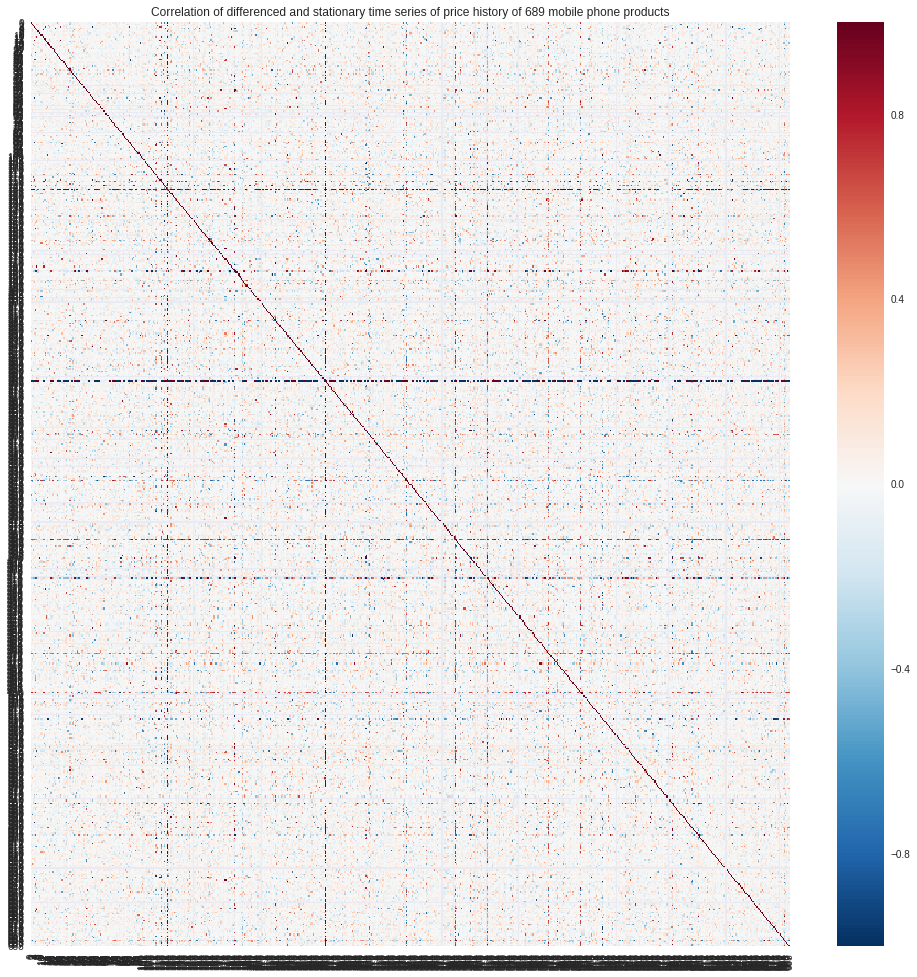

In [36]:
plt.figure(figsize=(17,17))
plt.title(
    'Correlation of differenced and stationary time series of price history of {} mobile phone products'.format(
        cur_len
    ))
sns.heatmap(corels)
plt.show()

In [37]:
corels_flat = corels[:].flatten()
corels_flat.shape

(474721,)

In [38]:
corels_filtered = corels_flat[corels_flat < 1]
corels_filtered.shape

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


(358728,)

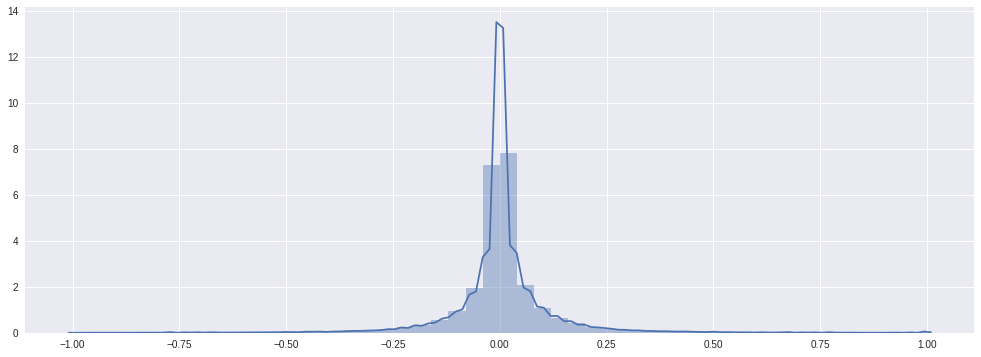

In [39]:
plt.figure(figsize=(17,6))
sns.distplot(corels_filtered)
plt.show()